In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
#RANDOM_STATE = 42

In [2]:
raw_data = pd.read_csv(r"C:\Users\Adir\Documents\NYPD-ML-Predictor\data\data.csv")
raw_data.head(3)

,INCIDENT_KEY,OCCUR_DATE,OCCUR_TIME,BORO,LOC_OF_OCCUR_DESC,PRECINCT,JURISDICTION_CODE,LOC_CLASSFCTN_DESC,LOCATION_DESC,STATISTICAL_MURDER_FLAG,...,PERP_SEX,PERP_RACE,VIC_AGE_GROUP,VIC_SEX,VIC_RACE,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,231974218,08/09/2021,01:06:00,BRONX,NaN,40,0.0,NaN,NaN,False,...,NaN,NaN,18-24,M,BLACK,1006343,234270,40.809673,-73.920193,POINT (-73.92019278899994 40.80967347200004)
1,177934247,04/07/2018,19:48:00,BROOKLYN,NaN,79,0.0,NaN,NaN,True,...,M,WHITE HISPANIC,25-44,M,BLACK,1000082.937500000000000,189064.671875000000000,40.685610,-73.942913,POINT (-73.94291302299996 40.685609672000055)
2,255028563,12/02/2022,22:57:00,BRONX,OUTSIDE,47,0.0,STREET,GROCERY/BODEGA,False,...,(null),(null),25-44,M,BLACK,1020691,257125,40.872349,-73.868233,POINT (-73.868233 40.872349)


In [3]:
raw_data.shape

(29744, 21)

In [4]:
raw_data.dtypes

INCIDENT_KEY                 int64
OCCUR_DATE                  object
OCCUR_TIME                  object
BORO                        object
LOC_OF_OCCUR_DESC           object
PRECINCT                     int64
JURISDICTION_CODE          float64
LOC_CLASSFCTN_DESC          object
LOCATION_DESC               object
STATISTICAL_MURDER_FLAG       bool
PERP_AGE_GROUP              object
PERP_SEX                    object
PERP_RACE                   object
VIC_AGE_GROUP               object
VIC_SEX                     object
VIC_RACE                    object
X_COORD_CD                  object
Y_COORD_CD                  object
Latitude                   float64
Longitude                  float64
Lon_Lat                     object
dtype: object

In [5]:
# Convert date and time columns
raw_data['OCCUR_DATE'] = pd.to_datetime(raw_data['OCCUR_DATE'], format='%m/%d/%Y')
raw_data['OCCUR_TIME'] = pd.to_datetime(raw_data['OCCUR_TIME'], format='%H:%M:%S').dt.time

# Convert integer and boolean types
raw_data['JURISDICTION_CODE'] = raw_data['JURISDICTION_CODE'].astype('Int64')
raw_data['STATISTICAL_MURDER_FLAG'] = raw_data['STATISTICAL_MURDER_FLAG'].astype(bool)

# Convert categorical columns
categorical_cols = ['BORO', 'PERP_SEX','PERP_RACE', 'PERP_AGE_GROUP',
'VIC_SEX', 'VIC_RACE', 'VIC_AGE_GROUP','LOC_OF_OCCUR_DESC', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC','PRECINCT']

for col in categorical_cols:
    raw_data[col] = raw_data[col].astype('category')

# Remove commas from coordinates (handle as string first)
raw_data['X_COORD_CD'] = raw_data['X_COORD_CD'].astype(str).str.replace(',', '')
raw_data['Y_COORD_CD'] = raw_data['Y_COORD_CD'].astype(str).str.replace(',', '')

# Convert to float
raw_data['X_COORD_CD'] = pd.to_numeric(raw_data['X_COORD_CD'], errors='coerce')
raw_data['Y_COORD_CD'] = pd.to_numeric(raw_data['Y_COORD_CD'], errors='coerce')

In [6]:
raw_data.dtypes

INCIDENT_KEY                        int64
OCCUR_DATE                 datetime64[ns]
OCCUR_TIME                         object
BORO                             category
LOC_OF_OCCUR_DESC                category
PRECINCT                         category
JURISDICTION_CODE                   Int64
LOC_CLASSFCTN_DESC               category
LOCATION_DESC                    category
STATISTICAL_MURDER_FLAG              bool
PERP_AGE_GROUP                   category
PERP_SEX                         category
PERP_RACE                        category
VIC_AGE_GROUP                    category
VIC_SEX                          category
VIC_RACE                         category
X_COORD_CD                        float64
Y_COORD_CD                        float64
Latitude                          float64
Longitude                         float64
Lon_Lat                            object
dtype: object

In [7]:
# Check the type of the first element in the column
print(type(raw_data['OCCUR_TIME'].iloc[0]))

<class 'datetime.time'>


##### נצטרך כנראה בעתיד לבנות עמודה חדשה של שעת הירי שנוכל להסתכל על השעות ולבצע עליהם כל מיני פעולות

In [8]:
raw_data.columns

Index(['INCIDENT_KEY', 'OCCUR_DATE', 'OCCUR_TIME', 'BORO', 'LOC_OF_OCCUR_DESC',
       'PRECINCT', 'JURISDICTION_CODE', 'LOC_CLASSFCTN_DESC', 'LOCATION_DESC',
       'STATISTICAL_MURDER_FLAG', 'PERP_AGE_GROUP', 'PERP_SEX', 'PERP_RACE',
       'VIC_AGE_GROUP', 'VIC_SEX', 'VIC_RACE', 'X_COORD_CD', 'Y_COORD_CD',
       'Latitude', 'Longitude', 'Lon_Lat'],
      dtype='object')

#### בדיקת עמודות - האם יש עמודות מיותרות?

In [9]:
# Define columns to drop
# INCIDENT_KEY: This is a unique identifier (high cardinality) with no predictive value. 
# Including it causes the model to memorize data (overfitting) rather than learn patterns.
# JURISDICTION_CODE: An administrative code irrelevant to the classification task 
# (predicting fatal vs. non-fatal shootings).
cols_to_drop = ['INCIDENT_KEY', 'JURISDICTION_CODE']

# Drop the columns from the dataset
raw_data.drop(columns=cols_to_drop, inplace=True, errors='ignore')

# Verify the columns were removed
print(f"Columns remaining: {len(raw_data.columns)}")

Columns remaining: 19


In [10]:
# List of location-related columns
raw_data[['X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude', 'Lon_Lat']].head(3)

,X_COORD_CD,Y_COORD_CD,Latitude,Longitude,Lon_Lat
0,1.006343e+06,234270.000000,40.809673,-73.920193,POINT (-73.92019278899994 40.80967347200004)
1,1.000083e+06,189064.671875,40.685610,-73.942913,POINT (-73.94291302299996 40.685609672000055)
2,1.020691e+06,257125.000000,40.872349,-73.868233,POINT (-73.868233 40.872349)


Correlation Matrix between coordinate systems:
            X_COORD_CD  Y_COORD_CD  Latitude  Longitude
X_COORD_CD    1.000000    0.138514  0.137934   0.999998
Y_COORD_CD    0.138514    1.000000  1.000000   0.140439
Latitude      0.137934    1.000000  1.000000   0.139860
Longitude     0.999998    0.140439  0.139860   1.000000


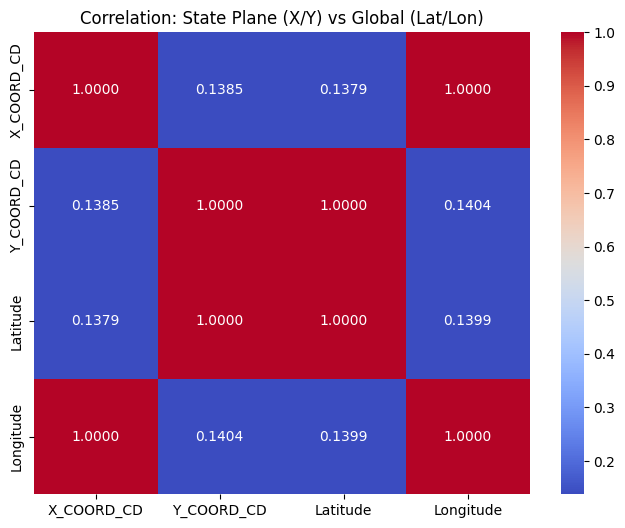


Sample comparison for 'Lon_Lat':
    Latitude  Longitude                                        Lon_Lat
0  40.809673 -73.920193   POINT (-73.92019278899994 40.80967347200004)
1  40.685610 -73.942913  POINT (-73.94291302299996 40.685609672000055)
2  40.872349 -73.868233                   POINT (-73.868233 40.872349)
3  40.642490 -73.996912  POINT (-73.99691224999998 40.642489932000046)
4  40.845984 -73.907461   POINT (-73.90746098599993 40.84598358900007)

Example value in 'Lon_Lat': POINT (-73.92019278899994 40.80967347200004)
Observation: If this value matches the Latitude/Longitude columns, 'Lon_Lat' can be dropped.


In [11]:
# 1. Check Correlation between coordinate systems
# X_COORD_CD and Y_COORD_CD represent the local projection (NY State Plane).
# Latitude and Longitude represent the global projection (WGS 1984).
# We expect a near-perfect correlation (close to 1.0 or -1.0) between them.
location_numeric = raw_data[['X_COORD_CD', 'Y_COORD_CD', 'Latitude', 'Longitude']].dropna()

# Calculate the correlation matrix
corr_matrix = location_numeric.corr()

print("Correlation Matrix between coordinate systems:")
print(corr_matrix)

# Visualization of the correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".4f")
plt.title("Correlation: State Plane (X/Y) vs Global (Lat/Lon)")
plt.show()

# 2. Inspect the 'Lon_Lat' column
# We need to verify if this column is redundant (e.g., just a string combination of Lat/Lon).
# This is often used for visualization tools but is not useful for ML models as a string.
print("\nSample comparison for 'Lon_Lat':")
print(raw_data[['Latitude', 'Longitude', 'Lon_Lat']].head())

# Check a single value to understand the format (e.g., "POINT (-73.9 40.8)")
if not raw_data['Lon_Lat'].dropna().empty:
    sample_val = raw_data['Lon_Lat'].dropna().iloc[0]
    print(f"\nExample value in 'Lon_Lat': {sample_val}")
    print("Observation: If this value matches the Latitude/Longitude columns, 'Lon_Lat' can be dropped.")

In [12]:
# Based on the correlation analysis and data inspection:
# 1. 'X_COORD_CD' and 'Y_COORD_CD' have a perfect correlation (~1.0) with Longitude/Latitude.
#    Keeping them would introduce multicollinearity without adding new information.
# 2. 'Lon_Lat' is a string representation ("POINT (...)") of the coordinates we already have.
#    Machine learning models cannot process this text format directly.

cols_to_drop_location = ['X_COORD_CD', 'Y_COORD_CD', 'Lon_Lat']

# Drop the redundant location columns
raw_data.drop(columns=cols_to_drop_location, inplace=True, errors='ignore')

# Verify that we are left with only the clean coordinate columns
print(f"Remaining location columns: {[col for col in raw_data.columns if col in ['Latitude', 'Longitude']]}")

Remaining location columns: ['Latitude', 'Longitude']


In [13]:
raw_data.duplicated().sum()

np.int64(0)

In [4]:
raw_data.describe(include=[np.number]).T[['min', 'max', 'mean', '50%']]

,min,max,mean,50%
INCIDENT_KEY,9.953245e+06,2.994625e+08,1.338510e+08,1.092920e+08
PRECINCT,1.000000e+00,1.230000e+02,6.522502e+01,6.700000e+01
JURISDICTION_CODE,0.000000e+00,2.000000e+00,3.181023e-01,0.000000e+00
Latitude,4.051159e+01,4.091082e+01,4.073951e+01,4.070322e+01
Longitude,-7.424930e+01,-7.370205e+01,-7.390903e+01,-7.391487e+01


In [14]:
# בדיקת ערכים ייחודיים בעמודות הדמוגרפיות
# המטרה: למצוא ערכים כמו '1020', 'UNKNOWN', '(null)'

categorical_cols = ['BORO', 'PERP_SEX', 'PERP_RACE', 'PERP_AGE_GROUP',
'VIC_SEX', 'VIC_RACE', 'VIC_AGE_GROUP','LOC_OF_OCCUR_DESC', 
'LOC_CLASSFCTN_DESC', 'LOCATION_DESC','PRECINCT']

print("--- Categorical Values Inspection ---")
for col in categorical_cols:
    if col in raw_data.columns:
        print(f"\n🔻 Column: {col}")
        # הצגת כל הערכים הייחודיים ברשימה
        print(raw_data[col].unique().tolist())

--- Categorical Values Inspection ---

🔻 Column: BORO
['BRONX', 'BROOKLYN', 'MANHATTAN', 'QUEENS', 'STATEN ISLAND']

🔻 Column: PERP_SEX
[nan, 'M', '(null)', 'U', 'F']

🔻 Column: PERP_RACE
[nan, 'WHITE HISPANIC', '(null)', 'UNKNOWN', 'BLACK', 'BLACK HISPANIC', 'ASIAN / PACIFIC ISLANDER', 'WHITE', 'AMERICAN INDIAN/ALASKAN NATIVE']

🔻 Column: PERP_AGE_GROUP
[nan, '25-44', '(null)', 'UNKNOWN', '18-24', '<18', '45-64', '65+', '1028', '1020', '940', '224', '2021']

🔻 Column: VIC_SEX
['M', 'F', 'U']

🔻 Column: VIC_RACE
['BLACK', 'WHITE HISPANIC', 'BLACK HISPANIC', 'ASIAN / PACIFIC ISLANDER', 'WHITE', 'UNKNOWN', 'AMERICAN INDIAN/ALASKAN NATIVE']

🔻 Column: VIC_AGE_GROUP
['18-24', '25-44', '<18', '45-64', '65+', 'UNKNOWN', '1022']

🔻 Column: LOC_OF_OCCUR_DESC
[nan, 'OUTSIDE', 'INSIDE']

🔻 Column: LOC_CLASSFCTN_DESC
[nan, 'STREET', 'OTHER', 'PLAYGROUND', 'TRANSIT', 'HOUSING', 'COMMERCIAL', 'DWELLING', 'VEHICLE', 'PARKING LOT', '(null)']

🔻 Column: LOCATION_DESC
[nan, 'GROCERY/BODEGA', 'PVT HOUSE

##### Hypothesis Testing: Do Missing Values Indicate Unsolved Crimes?